In [34]:
import pickle
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd

In [35]:
shap_tfbs = ["POPTR_0002s00440g", "DOF5.8", "TREE1", "BEE2", "AT5G04390", "AHL20", "P0510F09.23", "DOF5.3", "AT5G05790", "ARF39", "AT3G46070", "ARF16", "AT1G14600", "DOF5.7", "GT-2", "TSAR2", "Zm00001d035604", "ERF069", "GRF4", "SIZF2"]

### Load in the motifs 

In [36]:
import Bio.SeqIO as SeqIO
import numpy as np 
from sklearn.preprocessing import LabelEncoder
LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/LTR_classification_data/Sequence_files/test_LTRs.fasta", "fasta") if rec.description.split()[3] != "NAN"]
LTR_motifs = pd.read_csv("/data/xhorvat9/LTR_classification_data/TFBS/LTR_test_motifCounts.csv", sep="\t").set_index("ID")


# LTR ordering is identical to its motif representation
LTR_sequence_df = pd.DataFrame({"sequence": [str(rec.seq) for rec in LTRs], "ID": [rec.id for rec in LTRs], "label": [rec.description.split()[3] for rec in LTRs]})
LTR_sequence_df.set_index("ID", inplace=True)
LTR_sequence_df = LTR_sequence_df.merge(LTR_motifs, on="ID")[["sequence", "label"]]
X_motifs = LTR_sequence_df.merge(LTR_motifs, on="ID").drop(["sequence", "label"], axis= 1)
print("Indices for LTR sequences and motifs are identical: ", all(X_motifs.index == LTR_sequence_df.index))


X = np.array(LTR_sequence_df["sequence"].tolist())

le = LabelEncoder()
y = le.fit_transform(LTR_sequence_df["label"])

#X_motifs = LTR_motifs

Indices for LTR sequences and motifs are identical:  True


In [37]:
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X_motifs).toarray()

# score = clf.score(X, y)

### Load the trained GBC classifier 

In [12]:
X_motifs.shape

(141533, 654)

In [21]:
import tqdm
tfbs_performance = {}
GBC = pickle.load(open("GBC_model_FULL.pkl", "rb"))
for tfbs in tqdm.tqdm(shap_tfbs):

    # Turn feature of interest to 0
    X_modified = X_motifs.copy()
    X_modified[[tfbs]] = 0

    # Scale using TF-IDF
    tfidf = TfidfTransformer()
    X = tfidf.fit_transform(X_modified).toarray()

    # Run the classifier
    modified_score = GBC.score(X, y)

    tfbs_performance[tfbs] = modified_score

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


In [22]:
tfbs_performance

{'POPTR_0002s00440g': 0.824608666061706,
 'DOF5.8': 0.8236445099818511,
 'TREE1': 0.8178595735027223,
 'BEE2': 0.8200147459165155,
 'AT5G04390': 0.8240982304900182,
 'AHL20': 0.8246653811252269,
 'P0510F09.23': 0.8210923321234119,
 'DOF5.3': 0.8241833030852994,
 'AT5G05790': 0.8234743647912885,
 'ARF39': 0.8253743194192378,
 'AT3G46070': 0.8180580762250453,
 'ARF16': 0.8223400635208712,
 'AT1G14600': 0.8245803085299456,
 'DOF5.7': 0.825260889292196,
 'GT-2': 0.8254026769509982,
 'TSAR2': 0.825260889292196,
 'Zm00001d035604': 0.8250056715063521,
 'ERF069': 0.8253176043557169,
 'GRF4': 0.823502722323049,
 'SIZF2': 0.8254310344827587}

In [38]:
import tqdm
import random
from sklearn.metrics import balanced_accuracy_score

all_perfos = {}
GBC = pickle.load(open("GBC_model_FULL.pkl", "rb"))
for i in range(5):
    randomized_performance = {}
    for tfbs in tqdm.tqdm(shap_tfbs):

        # Turn feature of interest to 0
        X_modified = X_motifs.copy()
        mx = max(X_modified[[tfbs]].values)[0]
        X_modified[tfbs] = [random.randint(0, mx) for _ in range(len(X_modified[[tfbs]]))]
        # Scale using TF-IDF
        tfidf = TfidfTransformer()
        X = tfidf.fit_transform(X_modified).toarray()

        # Run the classifier
        predictions = GBC.predict(X)
        modified_score = balanced_accuracy_score(predictions, y )
        
        randomized_performance[tfbs] = modified_score
    all_perfos[i] = randomized_performance

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


In [45]:
dt = pd.DataFrame(all_perfos)
for i in range(5):
    dt[i] -= 0.8236445099818511
    dt[i] *= -100

Text(0.5, 0, 'Accuracy decrease (%)')

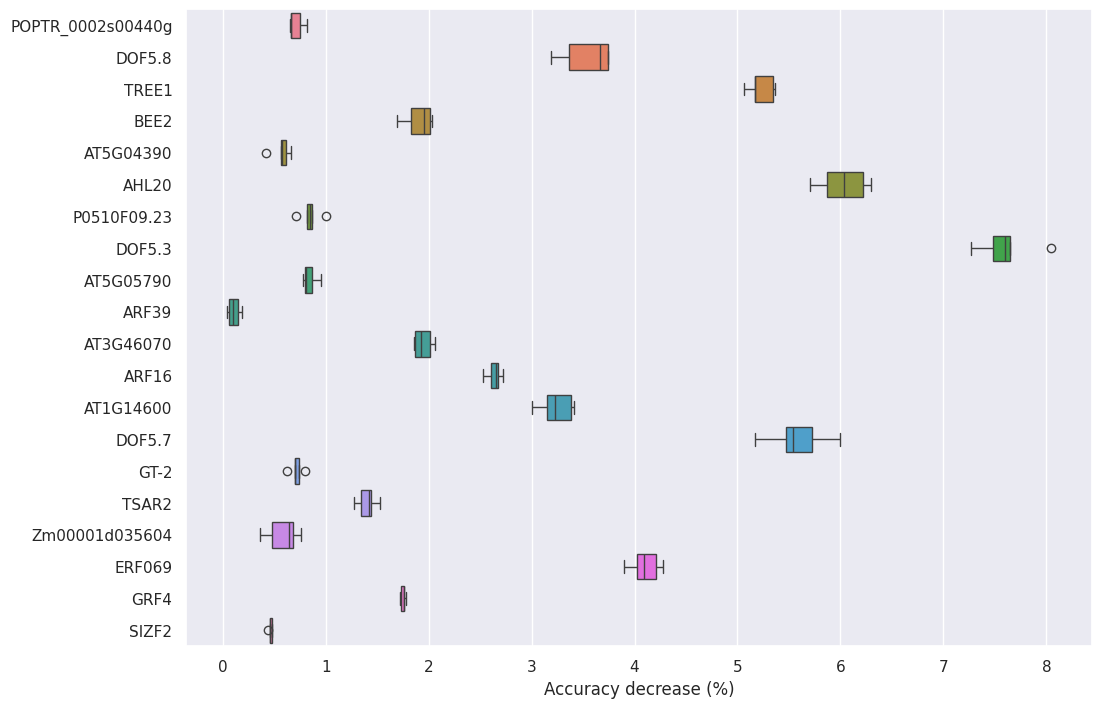

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
g = sns.boxplot(data=dt.T, orient="h")
g.set_xlabel("Accuracy decrease (%)")
#for x in shap_tfbs:
#    plt.axhline(y=x, lw=0.1) 

In [39]:
all_perfos_modified = all_perfos.deepcopy()
for i in range(5):
    for tfbs in all_perfos[i]:
        all_perfos_modified[i][tfbs] = round((0.8236445099818511- all_perfos[i][tfbs])*100, 3)



AttributeError: 'dict' object has no attribute 'deepcopy'

In [24]:
randomized_performance

{'POPTR_0002s00440g': 0.7949750453720508,
 'DOF5.8': 0.806119555353902,
 'TREE1': 0.7589042649727767,
 'BEE2': 0.8202132486388385,
 'AT5G04390': 0.8181431488203267,
 'AHL20': 0.7253856624319419,
 'P0510F09.23': 0.8142298094373865,
 'DOF5.3': 0.6813747731397459,
 'AT5G05790': 0.8225385662431942,
 'ARF39': 0.8136626588021778,
 'AT3G46070': 0.8102313974591652,
 'ARF16': 0.7410390199637024,
 'AT1G14600': 0.728193058076225,
 'DOF5.7': 0.6206612976406534,
 'GT-2': 0.8244952359346642,
 'TSAR2': 0.8160730490018149,
 'Zm00001d035604': 0.8234460072595281,
 'ERF069': 0.6873298548094374,
 'GRF4': 0.8125567150635209,
 'SIZF2': 0.8249205989110708}

In [27]:
pd.DataFrame(all_perfos)

,0,1,2,3,4
POPTR_0002s00440g,0.815671,0.815671,0.815671,0.815671,0.815671
DOF5.8,0.789009,0.789009,0.789009,0.789009,0.789009
TREE1,0.771995,0.771995,0.771995,0.771995,0.771995
BEE2,0.803776,0.803776,0.803776,0.803776,0.803776
AT5G04390,0.817226,0.817226,0.817226,0.817226,0.817226
AHL20,0.762383,0.762383,0.762383,0.762383,0.762383
P0510F09.23,0.818019,0.818019,0.818019,0.818019,0.818019
DOF5.3,0.749607,0.749607,0.749607,0.749607,0.749607
AT5G05790,0.813507,0.813507,0.813507,0.813507,0.813507
ARF39,0.822755,0.822755,0.822755,0.822755,0.822755


In [27]:
from sklearn.metrics import balanced_accuracy_score

# Scale using TF-IDF
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X_motifs).toarray()

# Run the classifier
predictions = GBC.predict(X)
balanced_accuracy_score(predictions, y )

0.8210222153983868

## Do the same for insignificant features